In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

from biosppy.signals import ecg
from scipy import signal
import heartpy as hp

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

pd.set_option('display.float_format', lambda x: '%.5f' % x)
# python display format: don't display sci notation

# Read data

In [2]:
def hdf_to_dict(hdf_file):
    # Read all the keys in the file
    with pd.HDFStore(hdf_file, mode='r') as hdf:
        keys = hdf.keys()

    # Read all tables, store in dictionary
    data = {}
    for key in keys: data[key] = pd.read_hdf(hdf_file, key)
    return data

In [3]:
raw_hdf = 'D:\data\ibeat\ibeat\Subject044\SE_GENERIC_DATA_EVENT_6671_001/Subject044_Device010_ibeatraw.hdf'
raw_data = hdf_to_dict(raw_hdf)

In [4]:
# alg_hdf = 'D:\data\ibeat\ibeat\Subject029\SE_GENERIC_DATA_EVENT_6671_002/Subject029_Device053_ibeat_alg.hdf'
# alg_data = hdf_to_dict(alg_hdf)

In [5]:
# raw_hdf2 = 'D:\data\ibeat\ibeat\Subject066\SE_GENERIC_DATA_EVENT_6671_001/Subject066_Device008_07202018_ibeatraw.hdf'
# raw_data2 = hdf_to_dict(raw_hdf2)

# raw_hdf2 = 'D:\data\ibeat\ibeat\Subject029\SE_GENERIC_DATA_EVENT_6671_001/Subject029_Device029_ibeatraw.hdf'
# raw_data2 = hdf_to_dict(raw_hdf2)

# PPG raw data

The iBeat raw data files have the following keys:
### Optical Data
 * /optical_streams/green/pkg1 - Green (~530nm) PPG signal from optical package (pkg) 1, ~25Hz
 * /optical_streams/green/pkg2 - Green (~530nm) PPG signal from optical packages (pkg) 2, ~50Hz
 * /optical_streams/red/pkg1, /optical_streams/red/pkg2 - Red PPG (~660nm) signal from optical packages 1 and 2, ~25Hz
 * /optical_streams/ir/pkg1, /optical_streams/ir/pkg2 - Infrared PPG (~940nm) signal from optical packages 1 and 2, ~25Hz
 
This data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pd1 - Raw ADC measurement from package 1 photodiode
* pd2 - Raw ADC measurement from package 2 photodiode
* drive_i - drive current of LED emittor
* gain_value - Analog front end amplifier gain
* pulse_count - Number of pulses averaged for a measurement (will not effect pd1/pd2 count since it is averaged, but will effect signal quiality (SNR)) (real count is 2^(pulse_count))

Note /optica_data is also a key, but it contains the raw stream of optical samples with all wavelengths and packages interleaved, so it is not typically useful for analysis purposes. The streams are build from this data

### Accel data
* /accel_data - Raw accelerometer reading, ~ 25Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* x, y, z - Raw measurements from the accelerometer, 4096 counts per G, (+/- 8G sensitivity)

### Contact Data
* /contact_data - Measurements from the metal contact pins on the bottom of device, ~2Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pad1 - Measurement from physical pad 1
* pad2 - Measurement from physical pad 2

The metal contact pin can be used as a fairly reliable boolean for contact. Their base value should be < 600, if making contact with skin, they will read > 800, usually around 2000

### Capacitance Data
* /cap_data - Measurements from the capacitive pads located on the sensorboard, just under bottom housing, ~2Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pad1 - Measurement from physical pad 1
* pad2 - Measurement from physical pad 2

Capacitance data is not as good for a clear binary yes/no that the device is being worn since they have more baseline variation and lower SNR. They are better at sensing the device sitting improperly, but requires some logic (that is taken into account in the contact algorithm)

In [5]:
# Sampling rate of PPG
# g_pkg1 = raw_data['/optical_streams/green/pkg1']
#data = g_pkg1.pd1[(g_pkg1.utc > 1524500000) & (g_pkg1.utc < 1524501000)]
#len(data)/(1524501000 - 1524500000)

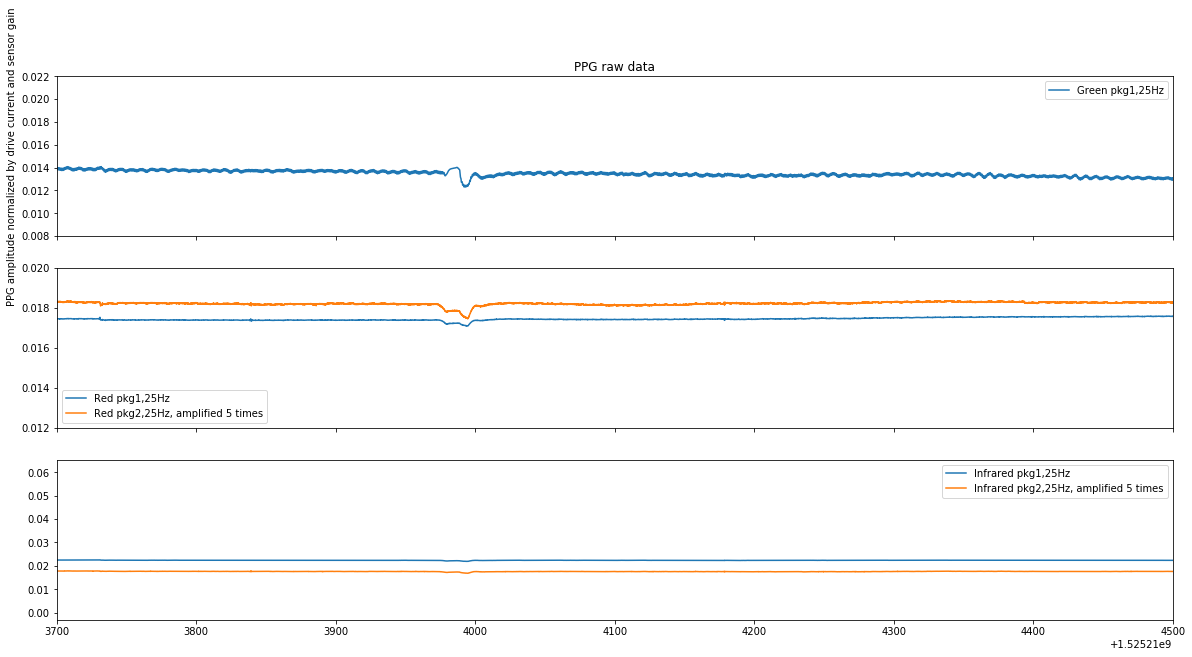

In [11]:
raw_data = raw_data2
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(20,10))


g_pkg1 = raw_data['/optical_streams/green/pkg1']
g_pkg2 = raw_data['/optical_streams/green/pkg2']
r_pkg1 = raw_data['/optical_streams/red/pkg1']
r_pkg2 = raw_data['/optical_streams/red/pkg2']
ir_pkg1 = raw_data['/optical_streams/ir/pkg1']
ir_pkg2 = raw_data['/optical_streams/ir/pkg2']

ts = 1525213700
te = 1525214500



ax[0].plot(g_pkg1.utc, g_pkg1.pd1 / g_pkg1.drive_i / g_pkg1.gain_value,label = 'Green pkg1,25Hz')
#ax[0].plot(g_pkg2.utc, g_pkg2.pd1 / g_pkg2.drive_i / g_pkg2.gain_value*80, label = 'Green pkg2,50Hz, amplified 40 times')
ax[0].legend()
ax[0].set_ylim(0.008,0.022)
ax[0].set_ylabel('PPG amplitude normalized by drive current and sensor gain')
ax[0].set_title('PPG raw data')
ax[0].set_xlim([ts,te])


ax[1].plot(r_pkg1.utc, r_pkg1.pd1 / r_pkg1.drive_i / r_pkg1.gain_value, label = 'Red pkg1,25Hz')
ax[1].plot(r_pkg2.utc, r_pkg2.pd1 / r_pkg2.drive_i / r_pkg2.gain_value*5, label = 'Red pkg2,25Hz, amplified 5 times')
ax[1].set_ylim(0.012,0.02)
ax[1].legend()


ax[2].plot(ir_pkg1.utc, ir_pkg1.pd1 / ir_pkg1.drive_i / ir_pkg1.gain_value, label = 'Infrared pkg1,25Hz')
ax[2].plot(ir_pkg2.utc, ir_pkg2.pd1 / ir_pkg2.drive_i / ir_pkg2.gain_value*5, label = 'Infrared pkg2,25Hz, amplified 5 times')
#ax[2].set_ylim(0.01,0.025)
ax[2].legend()


In [ ]:
raw_data.keys()

## Motion artifact

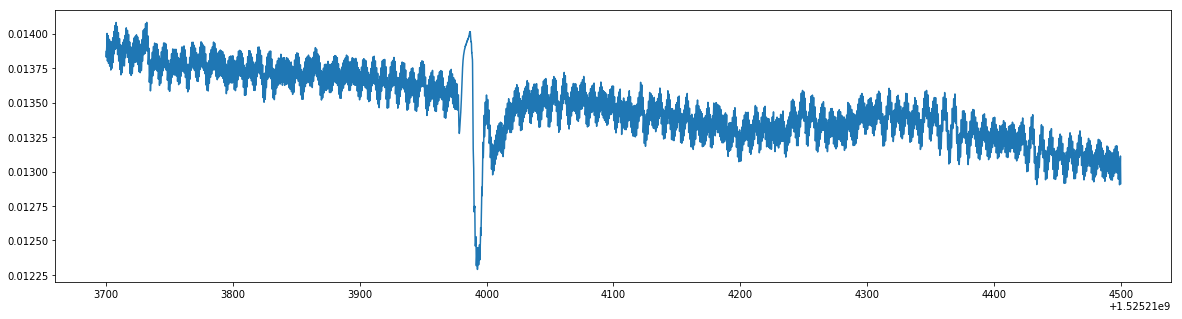

In [13]:
g_pkg1 = raw_data['/optical_streams/green/pkg1']

ppg_cut = g_pkg1[(g_pkg1['utc']> ts) & (g_pkg1['utc']< te)]
raw_ppg = ppg_cut.pd1 / ppg_cut.drive_i / ppg_cut.gain_value
plt.figure(figsize = (20,5))
plt.plot(ppg_cut.utc,raw_ppg)


In [26]:
utc = ppg_cut['utc'].values
ppg = raw_ppg.values

ppg_mtx = np.column_stack((utc, ppg))
ppg_mtx

array([[1.52521370e+09, 1.38704134e-02],
       [1.52521370e+09, 1.38453146e-02],
       [1.52521370e+09, 1.38294358e-02],
       ...,
       [1.52521450e+09, 1.29694179e-02],
       [1.52521450e+09, 1.29340747e-02],
       [1.52521450e+09, 1.29125614e-02]])

In [28]:
from sklearn.ensemble import IsolationForest as IF

# need to build raw_ppg as a 2D array, using time and value column

clf = IF(n_estimators=10)
clf.fit(ppg_mtx)
# clf = IF(n_estimators=10, warm_start=True)
# clf.fit(ppg_mtx)

# clf.set_params(n_estimators=20)

# clf.fit(raw_ppg)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=10, n_jobs=None,
        random_state=None, verbose=0)

## Respiration Artifacts and Noises

In [4]:
raw_data2 = raw_data
r_pkg2 = raw_data2['/optical_streams/red/pkg1']
ir_pkg2 = raw_data2['/optical_streams/ir/pkg1']
g_pkg2 = raw_data2['/optical_streams/green/pkg1']
# ts = 1525210300   #29
# te = 1525210330

# ts = 1532102500  #for66
# te = 1532102530

ts = 1527108400  #for44
te = 1527108430

highcut = 5  #8
lowcut = 0.8

ppg_cut_r = r_pkg2[(r_pkg2.utc>ts)&(r_pkg2.utc<te)]
raw_ppg_r = ppg_cut_r.pd1 / ppg_cut_r.drive_i / ppg_cut_r.gain_value
filtered_r = hp.filtersignal(data = raw_ppg_r, cutoff = 0.8, sample_rate = 25, order = 1, filtertype='highpass')
filtered_r = hp.filtersignal(data = filtered_r, cutoff = 3.5, sample_rate = 25, order = 1, filtertype='lowpass')

ppg_cut_ir = ir_pkg2[(ir_pkg2.utc>ts)&(ir_pkg2.utc<te)]
raw_ppg_ir = ppg_cut_ir.pd1 / ppg_cut_ir.drive_i / ppg_cut_ir.gain_value
filtered_ir = hp.filtersignal(data = raw_ppg_ir, cutoff = 0.8, sample_rate = 25, order = 1, filtertype='highpass')
filtered_ir = hp.filtersignal(data = filtered_ir, cutoff = 3.5, sample_rate = 25, order = 1, filtertype='lowpass')

ppg_cut_g = g_pkg2[(g_pkg2.utc>ts)&(g_pkg2.utc<te)]
raw_ppg_g = ppg_cut_g.pd1 / ppg_cut_g.drive_i / ppg_cut_g.gain_value
filtered_g = hp.filtersignal(data = raw_ppg_g, cutoff = 0.8, sample_rate = 25, order = 1, filtertype='highpass')
filtered_g = hp.filtersignal(data = filtered_g, cutoff = 3.5, sample_rate = 25, order = 1, filtertype='lowpass')

C:\Users\admin\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


### red

Text(0.5, 1.0, 'Respiration artifact & noise removed PPG data')

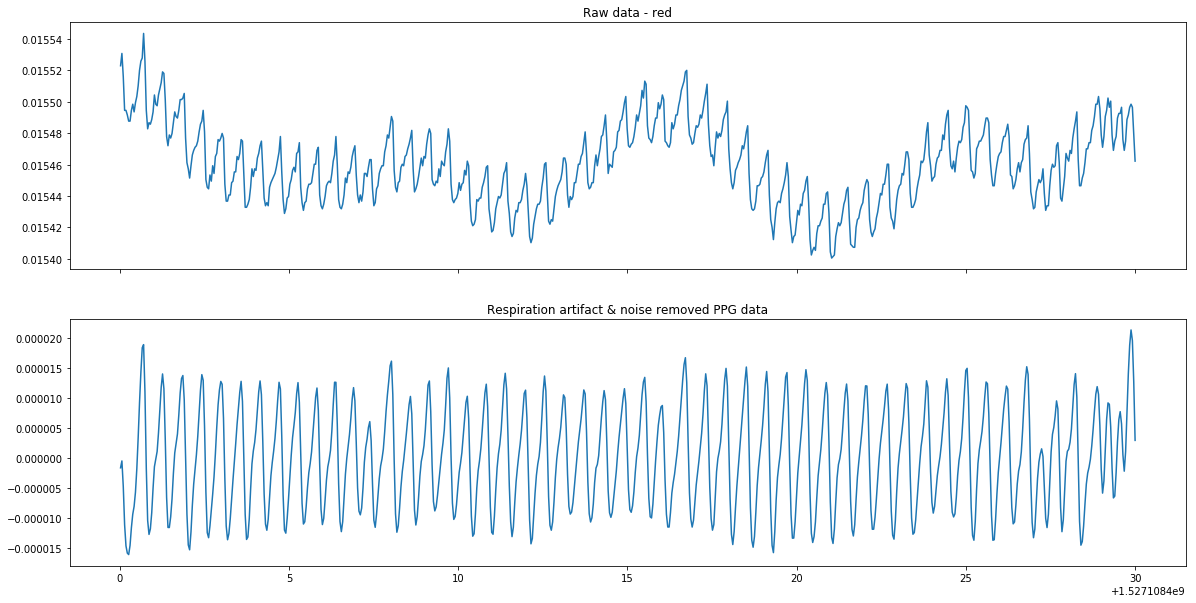

In [6]:
fig, ax = plt.subplots(2,1,sharex = True, figsize = (20,10))

ax[0].plot(ppg_cut_r.utc,raw_ppg_r)
ax[0].set_title('Raw data - red')
ax[1].plot(ppg_cut_r.utc,filtered_r)
ax[1].set_title('Respiration artifact & noise removed PPG data')

#plt.savefig('66red.png')

### ir

Text(0.5, 1.0, 'Respiration artifact & noise removed PPG data - ir')

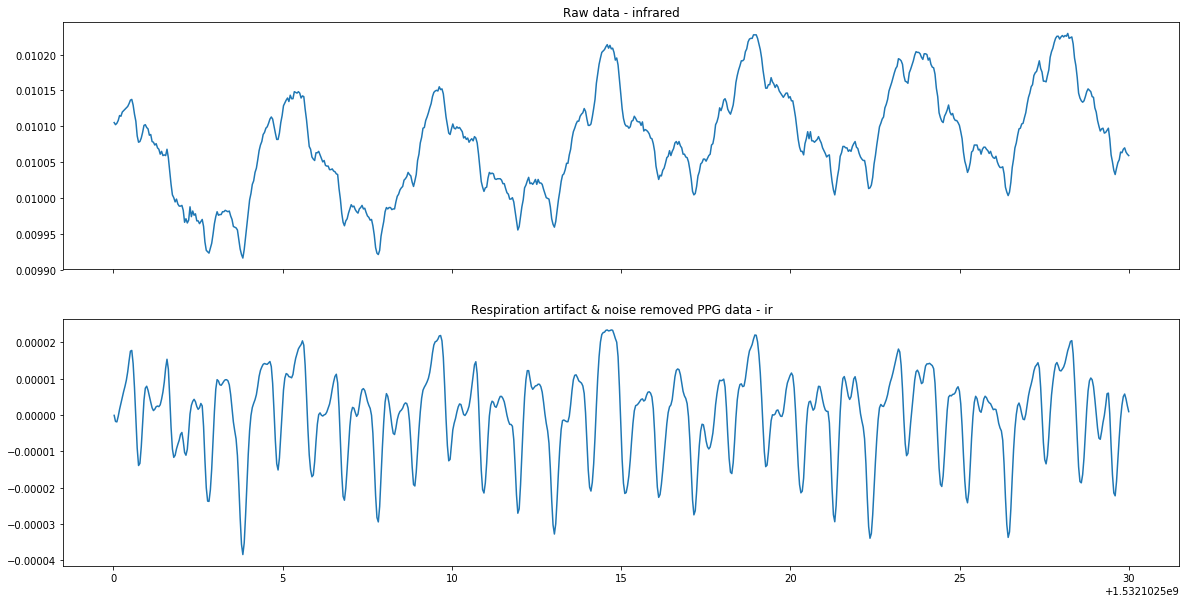

In [7]:
fig, ax = plt.subplots(2,1,sharex = True, figsize = (20,10))

ax[0].plot(ppg_cut_ir.utc,raw_ppg_ir)
ax[0].set_title('Raw data - infrared')
ax[1].plot(ppg_cut_ir.utc,filtered_ir)
ax[1].set_title('Respiration artifact & noise removed PPG data - ir')

In [5]:
res_g = hp.filtersignal(data = raw_ppg_g, cutoff = 0.3, sample_rate = 25, order = 1, filtertype='lowpass')
t = np.linspace(0,30,num = len(res_g))
t2 = np.linspace(0,30,num = len(raw_ppg_g))
t3 = np.linspace(0,30,num = len(filtered_g))

Text(0.5, 0, 'Time/sec')

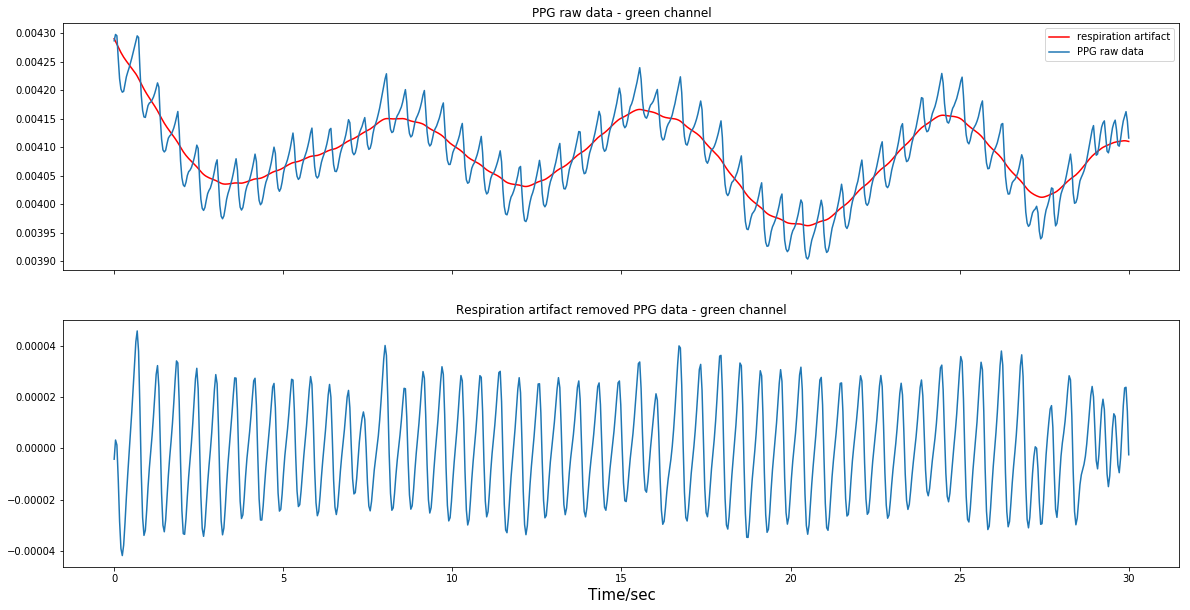

In [6]:


fig, ax = plt.subplots(2,1,sharex = True, figsize = (20,10))
ax[0].plot(t,res_g, c='r',label='respiration artifact')
ax[0].plot(t2,raw_ppg_g,label='PPG raw data')
ax[0].set_title('PPG raw data - green channel')
ax[0].legend()
ax[1].plot(t3,filtered_g)
ax[1].set_title('Respiration artifact removed PPG data - green channel')

ax[1].set_xlabel('Time/sec',fontsize = 15)

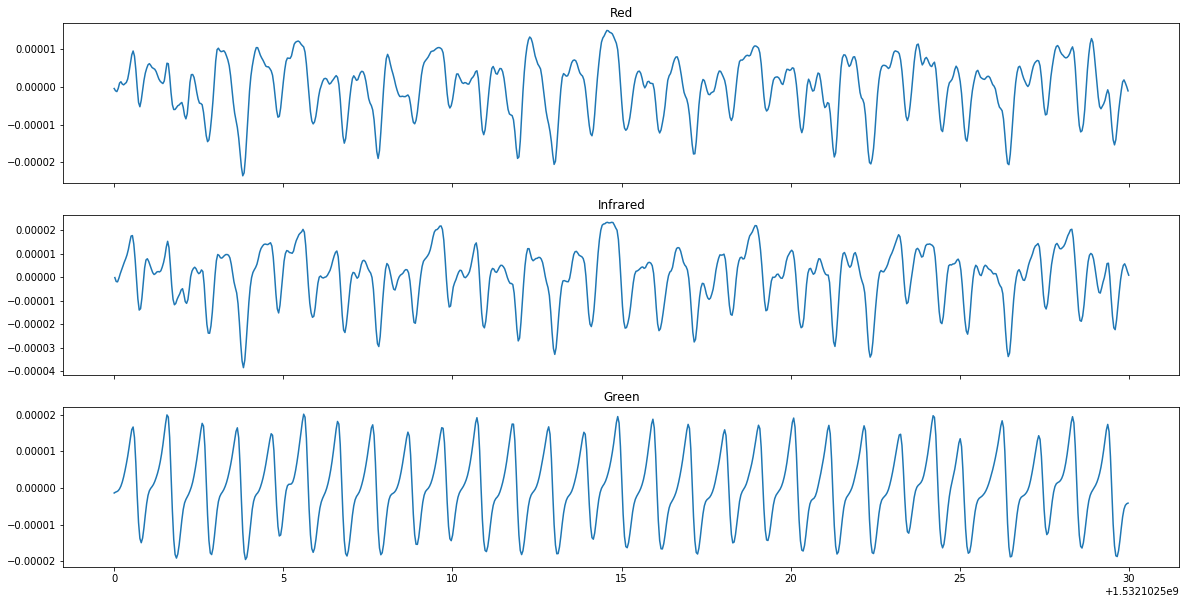

In [9]:
fig, ax = plt.subplots(3,1,sharex = True, figsize = (20,10))
ax[0].plot(ppg_cut_r.utc,filtered_r)
ax[0].set_title('Red')
ax[1].plot(ppg_cut_ir.utc,filtered_ir)
ax[1].set_title('Infrared')
ax[2].plot(ppg_cut_g.utc,filtered_g)
ax[2].set_title('Green')

#plt.savefig('66.png')

## 44

![44red](44red.png)

![44](44.png)

## 66

![66red](66red.png)

![66](66.png)

## 29

![29red](29red.png)

![29](29.png)